### Ideas

Save actual y_test for 40 and 40 (changes otherwise) so can just read in

In [1]:
%load_ext autoreload
%autoreload 3
from data_functions import get_dataset
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler as SRS
from train_utils import SubsetSampler as SS
from sklearn.model_selection import train_test_split as TTS
import torch
import random
import numpy as np
torch.use_deterministic_algorithms(True) # reproducibility

STATE = "SP"
WEEKS = False
TRIANGLE = True
PAST_UNITS = 40
MAX_DELAY = 40
RANDOM_SPLIT = True
SEED = 1234
DEVICE = "mps"

dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

def set_seeds(SEED):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    random.seed(SEED)

set_seeds(SEED)


/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


### Ideas

Change implement other function in metrics that translates dict to levels_dict, s.t. can call that for experiments, but else just store and read in from pickle for all models, compare and make plots of all together

In [2]:
%load_ext autoreload
%autoreload 3
from metrics import RIVM_to_dict, Epi_to_dict
import numpy as np

rivm_dict = RIVM_to_dict()
epi_dict = Epi_to_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dimensions are dictionary with specific test dates, then list of lists, which can be transformed into an array.

Has shape [14, 9, 2], meaning current date (index 0), along with 13 past dates, then 9 levels, from median to min and max, 7 standard levels in between

Then per level lower and upper bound

In [4]:
import pandas as pd
test_dates = pd.read_csv("test_dates.csv")

Read in correct values to evaluate model

Convert from dictionary per date to dictionary per level of same-day nowcast

In [3]:
from metrics import date_to_level_dict

levels_rivm = date_to_level_dict(rivm_dict)
levels_epi = date_to_level_dict(epi_dict)

In [8]:
## Save RIVM dict, so can be used after

import pickle
"""
with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_rivm, f)

with open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:
    pickle.dump(levels_epi, f)"""

"\nwith open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:\n    pickle.dump(levels_rivm, f)\n\nwith open('../data/model_predictions/rivm_dict.pkl', 'wb') as f:\n    pickle.dump(levels_epi, f)"

In [9]:
with open('../data/model_predictions/nowcast_pnn_dict.pkl', 'rb') as f:
    levels_pnn = pickle.load(f)


In [10]:
%load_ext autoreload
%autoreload 3
from metrics import evaluate_PIs

print("------ RIVM model ------")
rivm_coverages, rivm_pica, rivm_cwc, rivm_wis, rivm_is_scores = evaluate_PIs(levels_rivm, test_loader)
print("------ Epinowcast model ------")
epi_coverages, epi_pica, epi_cwc, epi_wis, epi_is_scores = evaluate_PIs(levels_epi, test_loader)
print("------ NowcastPNN model ------")
pnn_coverages, pnn_pica, pnn_cwc, pnn_wis, pnn_is_scores = evaluate_PIs(levels_pnn, test_loader)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
------ RIVM model ------
Actual coverage per level | 5%: 5.49 | 10%: 9.7 | 25%: 23.07 | 50%: 46.27 | 75%: 68.07 | 90%: 84.53 | 95%: 89.03 |
PICA: 0.03544303797468355
CWC: 0.2587956043242977
WIS: 250.3374279725725
IS: 781.4161973734148
IS: under = 106.60153665927594 | spread = 472.79753867791845 | over = 202.0171220362204 | total = 781.4161973734148
------ Epinowcast model ------
Actual coverage per level | 5%: 6.61 | 10%: 12.52 | 25%: 26.72 | 50%: 49.09 | 75%: 73.14 | 90%: 86.22 | 95%: 91.84 |
PICA: 0.02224231464737792
CWC: 0.24470832673384904
WIS: 305.22665527302786
IS: 949.9955032623753
IS: under = 300.84916581185735 | spread = 589.2480861965039 | over = 59.89825125401408 | total = 949.9955032623753
------ NowcastPNN model ------
Actual coverage per level | 5%: 5.2 | 10%: 8.3 | 25%: 23.07 | 50%: 46.55 | 75%: 68.35 | 90%: 84.11 | 95%: 89.73 |
PICA: 0.03584488647779788
CWC: 0.27504270292047656
WIS: 

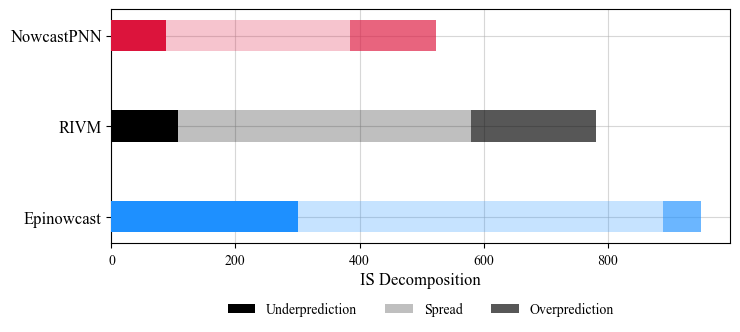

In [11]:
from plotting import plot_is_decomposition, plot_coverages, plot_wis, plot_pica

plot_is_decomposition(epi_scores=epi_is_scores, rivm_scores=rivm_is_scores, pnn_scores=pnn_is_scores)

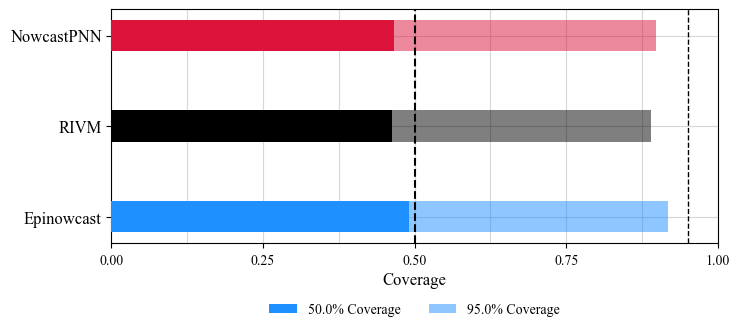

In [12]:
plot_coverages(epi_coverages=epi_coverages, rivm_coverages=rivm_coverages, pnn_coverages=pnn_coverages)

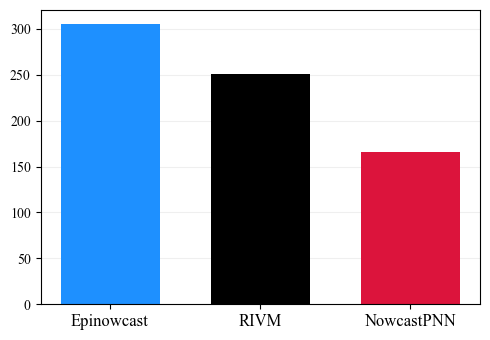

In [79]:
plot_wis(epi_wis, rivm_wis, pnn_wis)

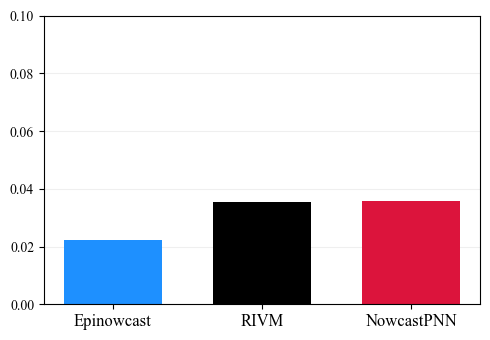

In [80]:
plot_pica(epi_pica, rivm_pica, pnn_pica)

Find PICA where better too, overall best

## For most recent dates as test set

In [13]:
RANDOM_SPLIT = False
dataset = get_dataset(weeks=WEEKS, triangle=TRIANGLE, past_units=PAST_UNITS, max_delay=MAX_DELAY, state=STATE)
## Define train and test indices
if RANDOM_SPLIT:
    all_idcs = range(dataset.__len__())
    train_idcs, test_idcs = TTS(all_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
    #train_idcs, test_idcs = [*range(600), *range(950, dataset.__len__())], [*range(600, 950)]
    VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
else:
    if WEEKS: # could also do random split, for now last indices as test
        train_idcs, test_idcs = range(300), range(300, dataset.__len__())
        TEST_BATCH_SIZE = dataset.__len__() - 300
    else: 
        train_idcs, test_idcs = range(2133), range(2133, dataset.__len__())
        train_idcs, val_idcs = TTS(train_idcs, test_size=0.25, shuffle=True, random_state=SEED)
        VAL_BATCH_SIZE, TEST_BATCH_SIZE = len(val_idcs), len(test_idcs)
        
## Define generator so sampling during training is deterministic and reproducible
g = torch.Generator()
g.manual_seed(SEED)
test_sampler = SS(test_idcs)
test_loader = DataLoader(dataset, batch_size=TEST_BATCH_SIZE, sampler=test_sampler, shuffle=False)

/Users/silaskoemen/Library/CloudStorage/OneDrive-ImperialCollegeLondon/Imperial/NowcastPNN/src/data_functions.py:103: DtypeWarning: Columns (7,11,23,45,46,47,55,65,69,75,86,102) have mixed types. Specify dtype option on import or set low_memory=False.
  dengdf = pd.read_csv(f"../data/derived/DENG{state}.csv", index_col=0)


2922 2013-01-01 00:00:00 2020-12-31 00:00:00


In [46]:
from metrics import RIVM_to_dict, date_to_level_dict, postprocess_rivm_level
rivm_dict = RIVM_to_dict(path= "../data/model_predictions/RIVM_list_recent.json")
levels_rivm = date_to_level_dict(rivm_dict)
levels_rivm = postprocess_rivm_level(levels_rivm)
epi_dict = Epi_to_dict(path= "../data/model_predictions/epinowcast_list_recent.json")
levels_epi = date_to_level_dict(epi_dict)
with open('../data/model_predictions/nowcast_pnn_dict_recent.pkl', 'rb') as f:
    levels_pnn = pickle.load(f)

In [48]:
from metrics import evaluate_PIs

print("------ RIVM model ------")
rivm_score_dict = evaluate_PIs(levels_rivm, test_loader)
print("------ Epinowcast model ------")
epi_score_dict = evaluate_PIs(levels_epi, test_loader)
print("------ NowcastPNN model ------")
pnn_score_dict = evaluate_PIs(levels_pnn, test_loader)

------ RIVM model ------
Actual coverage per level | 5%: 5.34 | 10%: 9.0 | 25%: 22.93 | 50%: 44.87 | 75%: 66.67 | 90%: 82.28 | 95%: 87.9 |
PICA: 0.045288326300984526
WIS: 313.4214658136002
IS: 974.3626620759587
IS: under = 134.1247845351776 | spread = 541.4175155716295 | over = 298.82036196915163 | total = 974.3626620759587
------ Epinowcast model ------
Actual coverage per level | 5%: 6.19 | 10%: 11.81 | 25%: 26.02 | 50%: 48.38 | 75%: 70.75 | 90%: 87.9 | 95%: 92.83 |
PICA: 0.020233072131806314
WIS: 357.8707966239242
IS: 1112.1429236476092
IS: under = 362.7116219992081 | spread = 657.7897528631705 | over = 91.64154878523077 | total = 1112.1429236476092
------ NowcastPNN model ------
Actual coverage per level | 5%: 5.77 | 10%: 11.67 | 25%: 24.33 | 50%: 48.66 | 75%: 73.28 | 90%: 86.92 | 95%: 92.83 |
PICA: 0.016315049226441624
WIS: 234.08095161456146
IS: 733.44994227834
IS: under = 59.83150797763278 | spread = 371.3269590114527 | over = 302.2914752892545 | total = 733.44994227834


In [ ]:
## Coverages, IS decomposition

In [ ]:
## Pica and WIS

### 2x2 plot of 50&95% PIs vs recent obs to show how much wider, how much worse

In [32]:
_, y = next(iter(test_loader))
y = y.to("cpu").numpy()

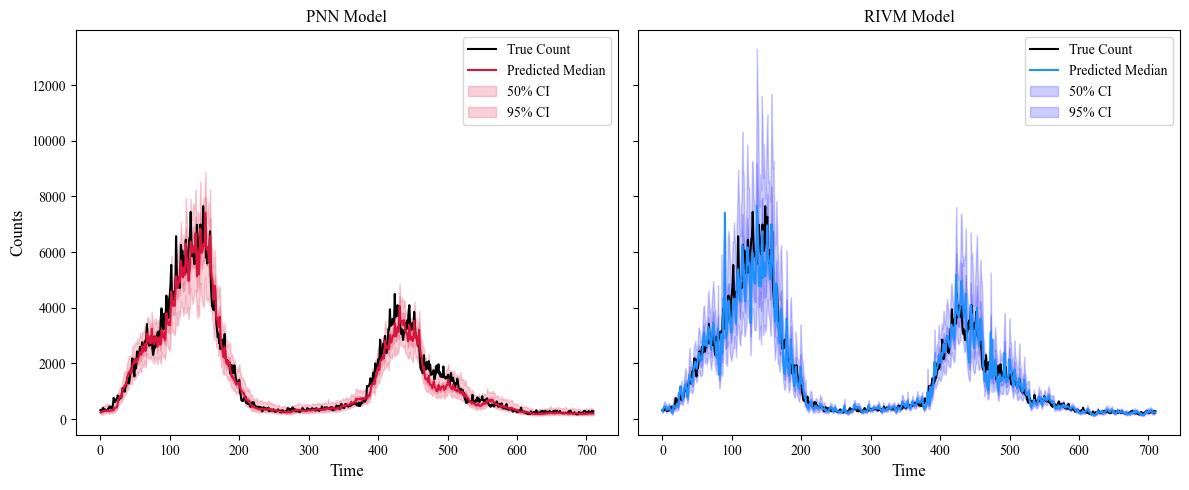

In [50]:
import matplotlib.pyplot as plt
# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Plot PNN model results
axs[0].plot(y, label='True Count', color='black')
axs[0].plot(levels_pnn[0], label='Predicted Median', color='crimson')

# Fill between for the confidence intervals
for l in [0.5, 0.95]:
    lower, upper = levels_pnn[l]
    axs[0].fill_between(range(len(y)), lower, upper, color='crimson', alpha=0.2, label=f'{int(100*l)}% CI')

axs[0].set_title('PNN Model')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Counts')
axs[0].legend()

# Plot RIVM model results
axs[1].plot(y, label='True Count', color='black')
axs[1].plot(levels_rivm[0], label='Predicted Median', color='dodgerblue')

# Fill between for the confidence intervals
for l in [0.5, 0.95]:
    lower, upper = levels_rivm[l]
    axs[1].fill_between(range(len(y)), lower, upper, color='blue', alpha=0.2, label=f'{int(100*l)}% CI')

axs[1].set_title('RIVM Model')
axs[1].set_xlabel('Time')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()

maybe add zoom in of around 100-200 idcs

## Past correction, pick date around outbreak in recent data, show how all models do

Can do 2x2 if dow separate model, else 1x3 possible with same date, show uncertainty intervals

Show how WIS and PICA move as function of days in the past, could do IS dec and coverages as average over all

### Could past correction on random split, but likely not very useful to add